In [1]:
# ============================
# 0. Install & imports
# ============================
# Run this ONCE in your environment (comment out afterwards if you like)
!pip install rtdl torch torchvision torchaudio --quiet


Using device: cpu
Training with 34 Numerical and 14 Categorical features.

Numerical features included:
  1. Age
  2. Weight (kg)
  3. Height (m)
  4. Max_BPM
  5. Avg_BPM
  6. Resting_BPM
  7. Session_Duration (hours)
  8. Fat_Percentage
  9. Water_Intake (liters)
  10. Workout_Frequency (days/week)
  11. Experience_Level
  12. BMI
  13. Daily meals frequency
  14. Physical exercise
  15. Carbs
  16. Proteins
  17. Fats
  18. Calories
  19. sugar_g
  20. sodium_mg
  21. cholesterol_mg
  22. serving_size_g
  23. prep_time_min
  24. cook_time_min
  25. rating
  26. Sets
  27. Reps
  28. BMI_calc
  29. cal_from_macros
  30. pct_carbs
  31. protein_per_kg
  32. pct_HRR
  33. pct_maxHR
  34. lean_mass_kg

Epoch | Train Loss   | Val RMSE   | Val R2    
--------------------------------------------------
1     | 0.1944       | 83.3896     | 0.9720
2     | 0.0316       | 52.9339     | 0.9887
3     | 0.0159       | 49.7646     | 0.9900
4     | 0.0110       | 42.8667     | 0.9926
5     | 0.0086 

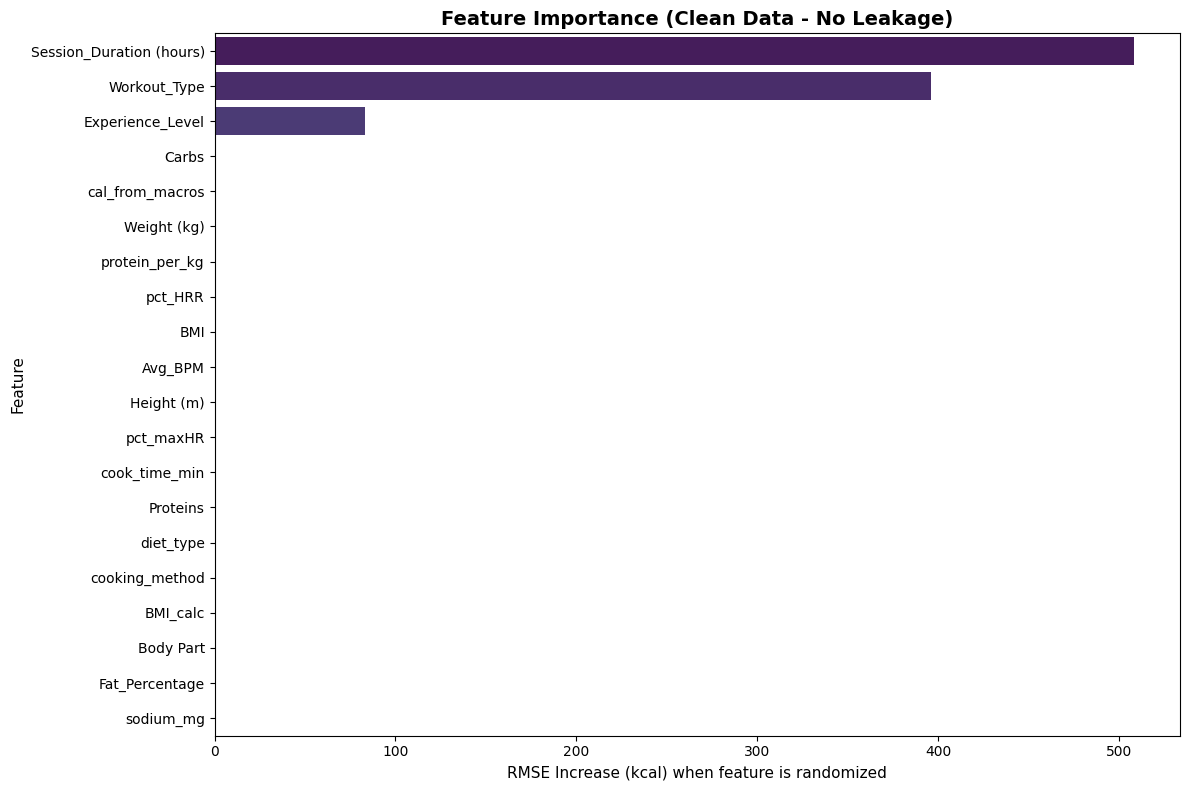

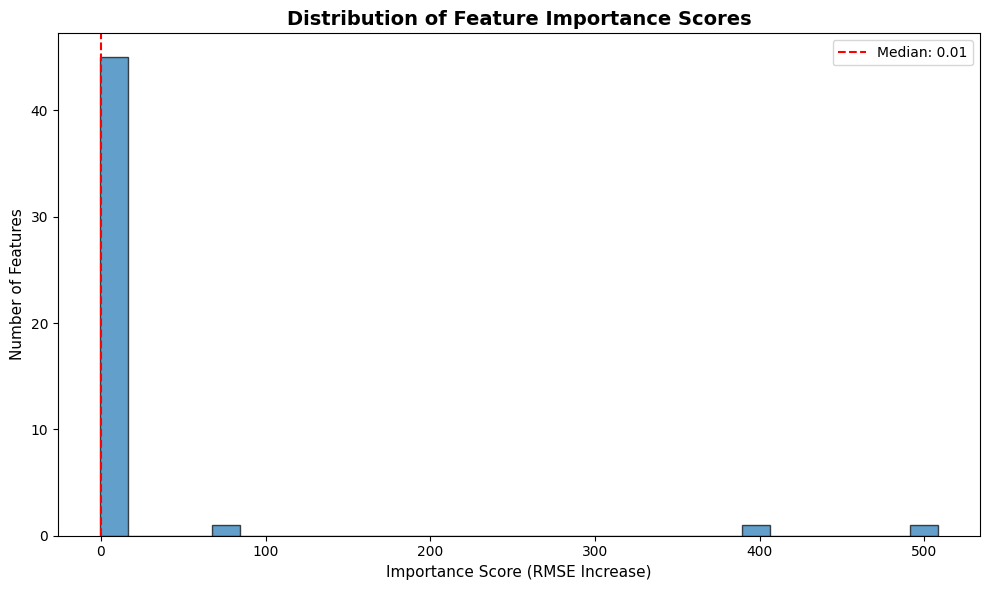

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
import rtdl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ------------------------------------------------------------------------------
# 1. DATA PREPARATION 
# ------------------------------------------------------------------------------

df = pd.read_csv('Final_data.csv')
target_col = 'Calories_Burned'

# REMOVING ALL POTENTIAL LEAKAGE FEATURES
drop_cols = [
    'Calories_Burned', 
    'Burns_Calories_Bin', 
    'Burns Calories (per 30 min)_bc',
    'Burns Calories (per 30 min)',  # <--- MAJOR LEAKAGE: burn rate (column 36)
    'cal_balance',                   # <--- Calculated from target
    'expected_burn'                 # <--- Proxy for target
]

categorical_cols = [
    'Gender', 'Workout_Type', 'meal_name', 'meal_type', 'diet_type', 
    'cooking_method', 'Name of Exercise', 'Benefit', 'Target Muscle Group', 
    'Equipment Needed', 'Difficulty Level', 'Body Part', 'Type of Muscle', 
    'Workout'
]

numerical_cols = [col for col in df.columns if col not in categorical_cols + drop_cols]

print(f"Training with {len(numerical_cols)} Numerical and {len(categorical_cols)} Categorical features.")
print(f"\nNumerical features included:")
for i, col in enumerate(numerical_cols, 1):
    print(f"  {i}. {col}")

# Prepare X and y
X_num = df[numerical_cols].astype(np.float32)
X_cat = df[categorical_cols].astype(str)
y = df[target_col].astype(np.float32).values.reshape(-1, 1)

# Split Data
X_num_train, X_num_temp, X_cat_train, X_cat_temp, y_train, y_temp = train_test_split(
    X_num, X_cat, y, test_size=0.3, random_state=42
)
X_num_val, X_num_test, X_cat_val, X_cat_test, y_val, y_test = train_test_split(
    X_num_temp, X_cat_temp, y_temp, test_size=0.5, random_state=42
)

# Scaling Features
scaler_x = StandardScaler()
X_num_train = scaler_x.fit_transform(X_num_train)
X_num_val = scaler_x.transform(X_num_val)
X_num_test = scaler_x.transform(X_num_test)

# Scaling Target (Critical for convergence)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

# Encoding Categoricals
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_cat_train = encoder.fit_transform(X_cat_train)
X_cat_val = encoder.transform(X_cat_val)
X_cat_test = encoder.transform(X_cat_test)

# Handle unknown categories
for col_idx in range(X_cat_train.shape[1]):
    cardinality = len(encoder.categories_[col_idx])
    X_cat_val[:, col_idx][X_cat_val[:, col_idx] == -1] = cardinality
    X_cat_test[:, col_idx][X_cat_test[:, col_idx] == -1] = cardinality

cardinalities = [len(cat) + 1 for cat in encoder.categories_]

# Convert to Tensors
def to_tensor(X_num, X_cat, y):
    return (
        torch.tensor(X_num, dtype=torch.float32).to(device),
        torch.tensor(X_cat, dtype=torch.long).to(device),
        torch.tensor(y, dtype=torch.float32).to(device)
    )

X_num_train_t, X_cat_train_t, y_train_t = to_tensor(X_num_train, X_cat_train, y_train_scaled)
X_num_val_t, X_cat_val_t, y_val_t = to_tensor(X_num_val, X_cat_val, y_val_scaled)
X_num_test_t, X_cat_test_t, y_test_t = to_tensor(X_num_test, X_cat_test, y_test_scaled)

# ------------------------------------------------------------------------------
# 2. MODEL & TRAINING
# ------------------------------------------------------------------------------

model = rtdl.FTTransformer.make_default(
    n_num_features=len(numerical_cols),
    cat_cardinalities=cardinalities,
    last_layer_query_idx=[-1], 
    d_out=1,
)

model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.MSELoss()

def train_epoch(model, optimizer, criterion, batch_size=256):
    model.train()
    train_loss = 0
    indices = torch.randperm(len(X_num_train_t))
    
    for i in range(0, len(X_num_train_t), batch_size):
        batch_idx = indices[i:i+batch_size]
        optimizer.zero_grad()
        y_pred = model(X_num_train_t[batch_idx], X_cat_train_t[batch_idx])
        loss = criterion(y_pred, y_train_t[batch_idx])
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(batch_idx)
        
    return train_loss / len(X_num_train_t)

def evaluate(model, X_num, X_cat, y_true_original):
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_num, X_cat)
        y_pred_original = scaler_y.inverse_transform(y_pred_scaled.cpu().numpy())
        y_true_np = y_true_original 
        
        rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_original))
        r2 = r2_score(y_true_np, y_pred_original)
    return rmse, r2

# Training Loop
epochs = 30
batch_size = 128
best_val_rmse = float('inf')

print(f"\n{'Epoch':<5} | {'Train Loss':<12} | {'Val RMSE':<10} | {'Val R2':<10}")
print("-" * 50)

for epoch in range(epochs):
    loss = train_epoch(model, optimizer, criterion, batch_size)
    val_rmse, val_r2 = evaluate(model, X_num_val_t, X_cat_val_t, y_val)
    
    print(f"{epoch+1:<5} | {loss:.4f}       | {val_rmse:.4f}     | {val_r2:.4f}")
    
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'best_ft_transformer_clean_final.pth')

# ------------------------------------------------------------------------------
# 3. FINAL TEST SET EVALUATION
# ------------------------------------------------------------------------------
print("\n" + "="*50)
print("FINAL TEST SET EVALUATION (NO LEAKAGE)")
print("="*50)
model.load_state_dict(torch.load('best_ft_transformer_clean_final.pth'))
test_rmse, test_r2 = evaluate(model, X_num_test_t, X_cat_test_t, y_test)
print(f"Test RMSE: {test_rmse:.4f} kcal")
print(f"Test R²: {test_r2:.4f}")
print(f"\nMean Calories Burned: {y_test.mean():.2f} kcal")
print(f"Std Calories Burned: {y_test.std():.2f} kcal")
print(f"RMSE as % of mean: {(test_rmse / y_test.mean() * 100):.2f}%")

# ------------------------------------------------------------------------------
# 4. FEATURE IMPORTANCE (PERMUTATION)
# ------------------------------------------------------------------------------
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

def get_permutation_importance(model, X_num, X_cat, y_true, n_repeats=3):
    model.eval()
    original_rmse, _ = evaluate(model, X_num, X_cat, y_true)
    importances = {}
    
    # Numerical
    for i, col_name in enumerate(numerical_cols):
        scores = []
        original_col = X_num[:, i].clone()
        for _ in range(n_repeats):
            X_num[:, i] = X_num[torch.randperm(X_num.size(0)), i]
            perm_rmse, _ = evaluate(model, X_num, X_cat, y_true)
            scores.append(perm_rmse - original_rmse)
            X_num[:, i] = original_col
        importances[col_name] = np.mean(scores)

    # Categorical
    for i, col_name in enumerate(categorical_cols):
        scores = []
        original_col = X_cat[:, i].clone()
        for _ in range(n_repeats):
            X_cat[:, i] = X_cat[torch.randperm(X_cat.size(0)), i]
            perm_rmse, _ = evaluate(model, X_num, X_cat, y_true)
            scores.append(perm_rmse - original_rmse)
            X_cat[:, i] = original_col
        importances[col_name] = np.mean(scores)
        
    return importances

importances = get_permutation_importance(model, X_num_test_t, X_cat_test_t, y_test)

# Plotting
imp_df = pd.DataFrame({
    'Feature': importances.keys(),
    'Importance': importances.values()
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Predictive Features:")
print(imp_df.head(20))

plt.figure(figsize=(12, 8))
sns.barplot(data=imp_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance (Clean Data - No Leakage)', fontsize=14, fontweight='bold')
plt.xlabel('RMSE Increase (kcal) when feature is randomized', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.tight_layout()
plt.savefig('feature_importance_final_clean.png', dpi=300)
plt.show()

# Distribution of importance scores
plt.figure(figsize=(10, 6))
plt.hist(imp_df['Importance'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Importance Score (RMSE Increase)', fontsize=11)
plt.ylabel('Number of Features', fontsize=11)
plt.title('Distribution of Feature Importance Scores', fontsize=14, fontweight='bold')
plt.axvline(imp_df['Importance'].median(), color='red', linestyle='--', label=f'Median: {imp_df["Importance"].median():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('importance_distribution.png', dpi=300)
plt.show()

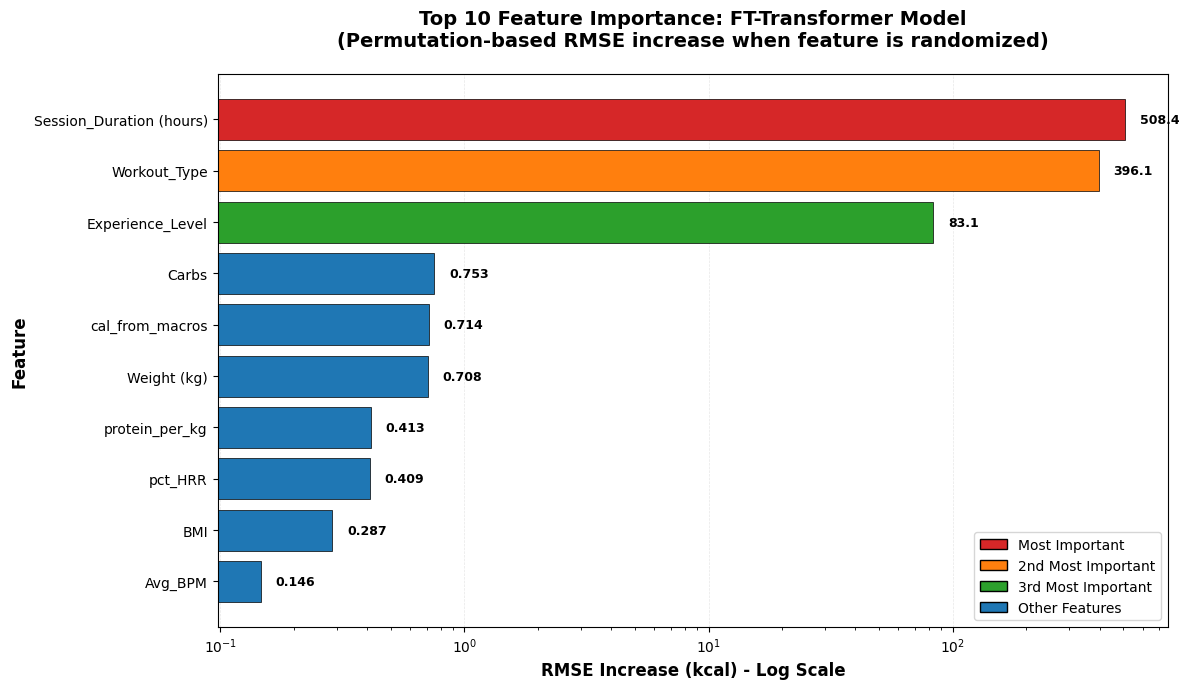


Top 10 Feature Importance Summary Statistics:
Top 3 features account for: 987.65 total RMSE increase
Ratio of 1st to 4th feature: 674.8x
Ratio of 1st to 10th feature: 3476.1x

Importance range: 0.1463 to 508.41
Median importance (Top 10): 0.7109
Mean importance (Top 10): 99.11


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your feature importance data (Top 10 only)
data = {
    'Feature': [
        'Session_Duration (hours)', 'Workout_Type', 'Experience_Level', 'Carbs',
        'cal_from_macros', 'Weight (kg)', 'protein_per_kg', 'pct_HRR',
        'BMI', 'Avg_BPM'
    ],
    'Importance': [
        508.405548, 396.145660, 83.093971, 0.753395, 0.713921, 0.707822,
        0.412717, 0.408694, 0.286994, 0.146257
    ]
}

imp_df = pd.DataFrame(data)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Create color palette - use different colors for top 3 features
colors = ['#d62728' if i == 0 else '#ff7f0e' if i == 1 else '#2ca02c' if i == 2 else '#1f77b4' 
          for i in range(len(imp_df))]

# Create horizontal bar plot
bars = ax.barh(imp_df['Feature'], imp_df['Importance'], color=colors, edgecolor='black', linewidth=0.5)

# Set log scale on x-axis
ax.set_xscale('log')

# Formatting
ax.set_xlabel('RMSE Increase (kcal) - Log Scale', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Feature Importance: FT-Transformer Model\n(Permutation-based RMSE increase when feature is randomized)', 
             fontsize=14, fontweight='bold', pad=20)

# Add grid for better readability
ax.grid(True, axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Invert y-axis so most important is at top
ax.invert_yaxis()

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, imp_df['Importance'])):
    if value >= 10:
        label = f'{value:.1f}'
    else:
        label = f'{value:.3f}'
    
    ax.text(value * 1.15, bar.get_y() + bar.get_height()/2, label,
            ha='left', va='center', fontsize=9, fontweight='bold')

# Add legend for color coding
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d62728', label='Most Important', edgecolor='black'),
    Patch(facecolor='#ff7f0e', label='2nd Most Important', edgecolor='black'),
    Patch(facecolor='#2ca02c', label='3rd Most Important', edgecolor='black'),
    Patch(facecolor='#1f77b4', label='Other Features', edgecolor='black')
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=10)

# Adjust layout
plt.tight_layout()
plt.savefig('feature_importance_log_scale.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nTop 10 Feature Importance Summary Statistics:")
print("=" * 50)
print(f"Top 3 features account for: {imp_df.head(3)['Importance'].sum():.2f} total RMSE increase")
print(f"Ratio of 1st to 4th feature: {imp_df.iloc[0]['Importance'] / imp_df.iloc[3]['Importance']:.1f}x")
print(f"Ratio of 1st to 10th feature: {imp_df.iloc[0]['Importance'] / imp_df.iloc[9]['Importance']:.1f}x")
print(f"\nImportance range: {imp_df['Importance'].min():.4f} to {imp_df['Importance'].max():.2f}")
print(f"Median importance (Top 10): {imp_df['Importance'].median():.4f}")
print(f"Mean importance (Top 10): {imp_df['Importance'].mean():.2f}")